In [1]:
%load_ext autoreload 
%autoreload 2|

In [2]:
from ase.io import read
import ase
import time 
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import (WignerDReal, ClebschGordanReal, 
                          spherical_expansion_reshape, spherical_expansion_conjugate,
                    lm_slice, real2complex_matrix, compute_lambda_soap, xyz_to_spherical, spherical_to_xyz)
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species,mask_center_atoms_by_id

In [3]:
from skcosmo.linear_model import AtomRidge
from skcosmo.model_selection import atom_groups_by_frame, train_test_split_by_frame

In [4]:
frames = read("CSD-3k+S546_shift_tensors.xyz","::20")
clean_frames = []
for f in frames:
    if f.info['STATUS'] == 'PASSING':
        clean_frames.append(f)
    else:
        print(f.info['NAME'], f.info['STATUS'])
frames = clean_frames

ORAVUZ SUSPICIOUS
SAJYEH SUSPICIOUS
DIZVOZ SUSPICIOUS
CUGLUN SUSPICIOUS


In [5]:
y = []
ty = []
s = []
atom_sigma = {'H': 0.1, 'C': 1, 'N':1, 'O':1, 'S':2}
type_idx = {'H': [], 'C': [], 'N': [], 'O': [], 'S': []}
idx = 0
groups = []
for iframe, f in enumerate(frames):
    y.append(f.arrays['cs_iso'])
    ty.append(f.arrays['cs_tensor'].reshape((-1,3,3)))
    f.wrap(eps=1e-12)
    for l in f.symbols:
        type_idx[l].append(idx)
        idx+=1
        s.append(atom_sigma[l])    
groups = atom_groups_by_frame(frames)        
cs = np.concatenate(y)
tcs = np.concatenate(ty)
sigmas = np.asarray(s)

In [6]:
f.info

{'magres_units': '_JSON \\"cs_tensor\\": \\"ppm\\", \\"cs_iso\\": \\"ppm\\"',
 'STATUS': 'PASSING',
 'NAME': 'FADBOB',
 'ENERGY': -2300.05217586}

In [7]:
hypers_1 = {
    'interaction_cutoff': 6,
    'max_radial': 10,
    'max_angular': 0,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',        
    'soap_type' : "RadialSpectrum",
    'normalize' : False
}

hypers_2 = {
    'interaction_cutoff': 6,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',
    'normalize' : False,
    'soap_type' : "PowerSpectrum"
}

hypers_1 = get_optimal_radial_basis_hypers(hypers_1, frames, expanded_max_radial=50)
hypers_2 = get_optimal_radial_basis_hypers(hypers_2, frames, expanded_max_radial=50)

In [8]:
soap1 = SphericalInvariants(**hypers_1)
soap2 = SphericalInvariants(**hypers_2)

In [9]:
feat1 = soap1.transform(frames).get_features(soap1)
feat2 = soap2.transform(frames).get_features(soap2)

In [10]:
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split

In [11]:
from skcosmo.kernel_model import RKHSTransform
from skcosmo.sample_selection import CUR, PCovCUR, FPS

In [12]:
feats = np.hstack([feat1, feat2])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [13]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,feat1.shape[1]), slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1])])

In [14]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [15]:
ar.fit(X_train, y_train, sample_sigmas=sig_train)

In [16]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 12545, 12546, 12547]),
                  array([  172,   173,   174, ..., 12397, 12398, 12399])),
                 (array([  172,   173,   174, ..., 12397, 12398, 12399]),
                  array([    0,     1,     2, ..., 12545, 12546, 12547]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [17]:
gcv.cv_results_

{'mean_fit_time': array([12.62226784, 11.41047299, 10.33597493, 10.8238939 , 11.28379452]),
 'std_fit_time': array([0.85140407, 0.25386012, 1.32430291, 0.82745206, 0.48295629]),
 'mean_score_time': array([1.31691337, 1.46901071, 1.0062598 , 1.15554893, 1.98514438]),
 'std_score_time': array([0.37100816, 0.07117593, 0.06159365, 0.19415653, 0.04891634]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-2990.80983736, -2809.06744737, -2569.79538167, -2640.59620488,
        -2649.73508213]),
 'split1_test_score': array([-2264.2629626 , -2030.42550369, -2193.61853362, -2079.42343749,
        -2077.68757716]),
 'mean_test_score': array([-2627.53639998, -2

In [18]:
cs_pred = gcv.predict(feats)

In [19]:
p_test = gcv.predict(X_test)

33.401580962589065

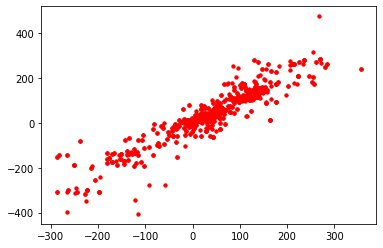

In [20]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

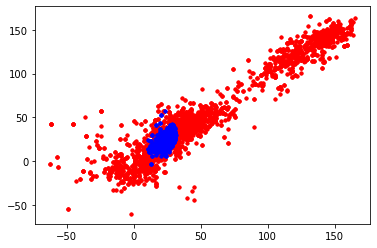

In [21]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')

In [22]:
sel = FPS(n_to_select = 1000, progress_bar=tqdm)

In [23]:
sel.fit(feats)

FPS()

In [24]:
KBB1 = (feat1[sel.selected_idx_]@feat1[sel.selected_idx_].T)**2
KBB2 = (feat2[sel.selected_idx_]@feat2[sel.selected_idx_].T)**2

In [25]:
rkhs1 = RKHSTransform(jitter=1e-10)
rkhs1.fit(KBB1)
rkhs2 = RKHSTransform(jitter=1e-10)
rkhs2.fit(KBB2)

In [26]:
feats = np.hstack([rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [27]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,rkhs1.nB_), slice(rkhs1.nB_,rkhs1.nB_+rkhs2.nB_)])
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [28]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([   48,    49,    50, ..., 12806, 12807, 12808]),
                  array([    0,     1,     2, ..., 12658, 12659, 12660])),
                 (array([    0,     1,     2, ..., 12658, 12659, 12660]),
                  array([   48,    49,    50, ..., 12806, 12807, 12808]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 961, None),
                                                 slice(961, 1961, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [29]:
gcv.cv_results_

{'mean_fit_time': array([0.57306707, 0.56071413, 0.57852292, 0.59785664, 0.66454113]),
 'std_fit_time': array([0.00267851, 0.00508988, 0.00524592, 0.00488198, 0.05927074]),
 'mean_score_time': array([0.08969927, 0.08821619, 0.09062922, 0.09227931, 0.10231376]),
 'std_score_time': array([2.85792351e-03, 5.90682030e-04, 4.64916229e-06, 3.19838524e-04,
        2.43973732e-03]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-6871.25681638, -4275.81785461, -2327.1206239 , -2435.99582069,
        -3313.62749191]),
 'split1_test_score': array([-8311.50051452, -4682.43061987, -1994.2089419 , -2013.5957211 ,
        -3163.56645951]),
 'mean_test_score': ar

In [30]:
cs_pred = gcv.predict(feats)

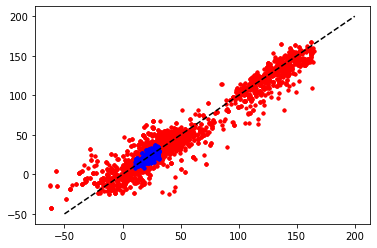

In [31]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [32]:
p_test = gcv.predict(X_test)

37.9234057386919

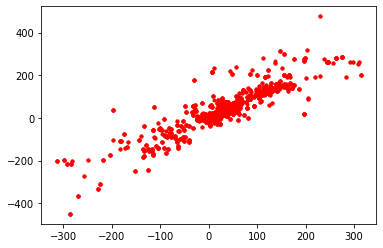

In [33]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

In [34]:
feats = np.hstack([feat1, feat2, rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
ar = AtomRidge(sigma=1, delta=[10, 2], 
               feature_groups=[slice(0,feat1.shape[1]),
                               slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1]),
                               slice(feat1.shape[1]+feat2.shape[1],feat1.shape[1]+feat2.shape[1]+rkhs1.nB_),
                               slice(feat1.shape[1]+feat2.shape[1]+rkhs1.nB_,
                                     feat1.shape[1]+feat2.shape[1]+rkhs1.nB_+rkhs2.nB_)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [35]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,1,1,1], [10,1,1,1], [1, 10, 1, 1], [1, 1, 1,10]]), cv = splits, scoring='neg_mean_squared_error')

In [36]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 12873, 12874, 12875]),
                  array([   86,    87,    88, ..., 12605, 12606, 12607])),
                 (array([   86,    87,    88, ..., 12605, 12606, 12607]),
                  array([    0,     1,     2, ..., 12873, 12874, 12875]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None),
                                                 slice(6770, 7731, None),
                                                 slice(7731, 8731, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 1, 1, 1], [10, 1, 1, 1], [1, 10, 1, 1],
                                   [1, 1, 1, 10]]},
             scoring='neg_mean_squared_error')

In [37]:
gcv.cv_results_

{'mean_fit_time': array([ 9.85993683, 13.27722335, 12.66051674, 11.67009723]),
 'std_fit_time': array([1.35135758, 1.50251627, 0.07989526, 0.10312021]),
 'mean_score_time': array([1.03893089, 1.13393652, 1.11975455, 0.98259676]),
 'std_score_time': array([0.07027054, 0.11650789, 0.00368428, 0.00716817]),
 'param_delta': masked_array(data=[list([1, 1, 1, 1]), list([10, 1, 1, 1]),
                    list([1, 10, 1, 1]), list([1, 1, 1, 10])],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 1, 1, 1]},
  {'delta': [10, 1, 1, 1]},
  {'delta': [1, 10, 1, 1]},
  {'delta': [1, 1, 1, 10]}],
 'split0_test_score': array([-2254.38191997, -2350.89008397, -2407.5595815 , -4178.02238631]),
 'split1_test_score': array([-1904.86760492, -1755.33312981, -2329.76061556, -5183.96133146]),
 'mean_test_score': array([-2079.62476245, -2053.11160689, -2368.66009853, -4680.99185888]),
 'std_test_score': array([174.75715753, 297.77847

In [53]:
cs_pred = gcv.predict(feats)

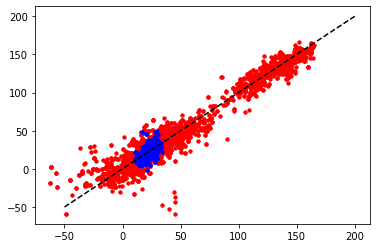

In [54]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [55]:
p_test = gcv.predict(X_test)

33.52512284197961

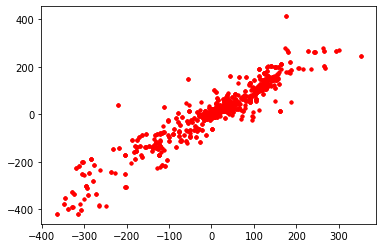

In [56]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

# Tensor stuff

In [50]:
cg = ClebschGordanReal(lmax=2)

In [51]:
tcs_coupled = cg.couple(xyz_to_spherical(tcs))

In [52]:
tcs_cart = spherical_to_xyz(cg.decouple(tcs_coupled))

In [53]:
tcs[0]

array([[  61.3422, -101.3244,   47.903 ],
       [-105.0865,  -13.6984,  -34.2244],
       [  35.4635,  -54.8832,   60.0297]])

In [54]:
print(tcs_coupled[(1,1)][0][0], tcs_coupled[(1,1)][1][0], tcs_coupled[(1,1)][2][0])

[-62.16532421] [-8.7960548   2.66020642 14.60797757] [-145.9545471   -63.00858822   29.5635449    58.94901747   53.06171712]


In [55]:
tcs_cart[0]

array([[  61.3422, -101.3244,   47.903 ],
       [-105.0865,  -13.6984,  -34.2244],
       [  35.4635,  -54.8832,   60.0297]])

In [56]:
cs[0]*np.sqrt(3)

62.163303483647006

In [57]:
tcs[0].trace()/3

35.89116666666666

In [58]:
tcs_coupled[(1,1)][2]

array([[-145.9545471 ,  -63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       [ 145.9545471 ,  -63.00858822,   29.5635449 ,  -58.94901747,
          53.06171712],
       [ 145.9545471 ,   63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       ...,
       [   3.03405378,   -3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218],
       [  -3.03405378,    3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218],
       [   3.03405378,   -3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218]])

## builds lambda-SOAP

In [6]:
hypers_2 = {
    'interaction_cutoff': 6,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR'
}
hypers_2 = get_optimal_radial_basis_hypers(hypers_2, frames, expanded_max_radial=50)

In [7]:
CG = ClebschGordanReal(lmax=hypers_2["max_angular"])

In [8]:
spex = SphericalExpansion(**hypers_2)

In [83]:
feats = spex.transform(frames).get_features(spex)
ref_feats = 1e3*spherical_expansion_reshape(feats, **hypers_2)

In [84]:
nsmall = 500

In [85]:
lsoap = compute_lambda_soap(ref_feats[:nsmall], CG, 2)

this is a simple PCA contraction

In [86]:
lsr = np.moveaxis(lsoap,-1,1).reshape((lsoap.shape[0]*lsoap.shape[-1], -1))

In [87]:
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)

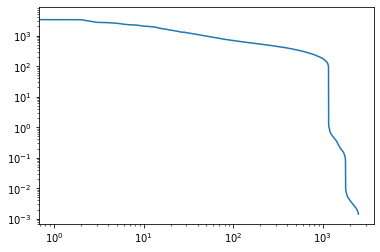

In [88]:
plt.loglog(s)

In [89]:
vt.shape

(2500, 25600)

In [90]:
lsoap_pca = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap.shape[0], lsoap.shape[-1], -1)), 1, -1)

In [91]:
lsoap_pca.shape

(500, 1000, 5)

now do 0-1-2

In [101]:
lsoap0 = compute_lambda_soap(ref_feats[:nsmall], CG, 0, 0)
lsr = np.moveaxis(lsoap0,-1,1).reshape((lsoap0.shape[0]*lsoap0.shape[-1], -1))
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)

In [92]:
from sklearn.linear_model import Ridge

In [93]:
class SASplitter:
    """ CV splitter that takes into account the presence of "L blocks"
    associated with symmetry-adapted regression. Basically, you can trick conventional
    regression schemes to work on symmetry-adapted data y^M_L(A_i) by having the (2L+1)
    angular channels "unrolled" into a flat array. Then however splitting of train/test
    or cross validation must not "cut" across the M block. This takes care of that.
    """
    def __init__(self, L, cv=2):
        self.L = L
        self.cv = cv
        self.n_splits = cv

    def split(self, X, y, groups=None):

        ntrain = X.shape[0]
        if ntrain % (2*self.L+1) != 0:
            raise ValueError("Size of training data is inconsistent with the L value")
        ntrain = ntrain // (2*self.L+1)
        nbatch = (2*self.L+1)*(ntrain//self.n_splits)
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        for n in range(self.n_splits):
            itest = idx[n*nbatch:(n+1)*nbatch]
            itrain = np.concatenate([idx[:n*nbatch], idx[(n+1)*nbatch:]])
            yield itrain, itest

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits
    
class SARidge(Ridge):
    """ Symmetry-adapted ridge regression class """

    def __init__(self, L, alpha=1, alphas=None, cv=2, solver='auto',
                 fit_intercept=False, scoring='neg_root_mean_squared_error'):
        self.L = L
        # L>0 components have zero mean by symmetry
        if L>0:
            fit_intercept = False
        self.cv = SASplitter(L, cv)
        self.alphas = alphas
        self.cv_stats = None
        self.scoring = scoring
        self.solver = solver
        super(SARidge, self).__init__(alpha=alpha, fit_intercept=fit_intercept, solver=solver)

    def fit(self, Xm, Ym, X0=None):
        # this expects properties in the form [i, m] and features in the form [i, q, m]
        # in order to train a SA-GPR model the m indices have to be moved and merged with the i

        Xm_flat = np.moveaxis(Xm, 2, 1).reshape((-1, Xm.shape[1]))
        Ym_flat = Ym.flatten()
        if self.alphas is not None:
            # determines alpha by grid search
            rcv = Ridge(fit_intercept=self.fit_intercept)
            gscv = GridSearchCV(rcv, dict(alpha=self.alphas), cv=self.cv, scoring=self.scoring)
            gscv.fit(Xm_flat, Ym_flat)
            self.cv_stats = gscv.cv_results_
            self.alpha = gscv.best_params_["alpha"]

        super(SARidge, self).fit(Xm_flat, Ym_flat)
    def predict(self, Xm, X0=None):

        Y = super(SARidge, self).predict(np.moveaxis(Xm, 2, 1).reshape((-1, Xm.shape[1])))
        return Y.reshape((-1, 2*self.L+1))

In [94]:
tgt0 = tcs_coupled[(1,1)][0][:nsmall]
tgt1 = tcs_coupled[(1,1)][1][:nsmall]
tgt2 = tcs_coupled[(1,1)][2][:nsmall]

In [99]:
sar0 = SARidge(L=0, alpha=1e-8)
sar1 = SARidge(L=0, alpha=1e-8)
sar2 = SARidge(L=0, alpha=1e-8)

In [96]:
sar0.fit(lsoap_pca, tgt)

In [97]:
pred = sar.predict(lsoap_pca)

In [98]:
pred

array([[-146.06110104,  -62.45600929,   29.45890017,   58.89890078,
          52.75158594],
       [ 146.06227312,  -62.45718553,   29.45863174,  -58.89821988,
          52.75282588],
       [ 146.06160222,   62.45821775,   29.45829112,   58.89774792,
          52.75302877],
       ...,
       [ -22.54198138,    9.54173894,  -10.20029496,  -10.64388952,
           7.04538645],
       [  24.68580685,  -10.38951916,  -10.27640242,  -14.04975365,
           4.90882667],
       [ -24.67287818,   10.41448863,  -10.27313732,  -14.05283799,
           4.90994857]])

In [82]:
tgt

array([[-145.9545471 ,  -63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       [ 145.9545471 ,  -63.00858822,   29.5635449 ,  -58.94901747,
          53.06171712],
       [ 145.9545471 ,   63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       ...,
       [ -22.88940006,   10.46482681,  -10.3575449 ,  -12.1693077 ,
           5.89281578],
       [  22.88692519,  -10.4627762 ,  -10.35746325,  -12.16789349,
           5.89776553],
       [ -22.88940006,   10.46482681,  -10.3575449 ,  -12.1693077 ,
           5.89281578]])